# EXPLORATORY DATA ANALYSIS (EDA)

Exploratory Data Analysis (EDA) is crucial for understanding the data, spotting anomalies or outliers, and ensuring that data is clean and ready for modeling. This notebook contains a structured approach for EDA on my `books_df` DataFrame (which I will use for clustering):

**Justification for EDA:**

- By checking for zero values in 'pages', I ensure data quality, as books with zero pages are likely data entry errors.
- Cleaning the 'genre' text values helps in grouping the books correctly and improves the model's performance.
- Visualizing distributions helps to understand the dataset's characteristics and to identify any anomalies or outliers that may affect the clustering model.
- Correlation analysis helps to find any linear relationship between numerical features, which might inform the feature selection process for the clustering model.
- Word clouds can provide insights into the common themes in book descriptions, potentially revealing subgenres or trends that could be useful for recommendations.

## Import Libraries

In [1]:
!pip install wordcloud

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re

## Load Data

In [3]:
books_df = pd.read_csv('books_df_cleaned.csv')

## Check head, shape and info

In [4]:
books_df.head()

,author,description,genre,image_url,url,pages,rating,reviews,title,total_ratings
0,Laurence M. Hauptman,Reveals that several hundred thousand Indians ...,"History,Military History,Civil War,American Hi...",https://i.gr-assets.com/images/S/compressed.ph...,https://goodreads.com/book/show/1001053.Betwee...,0,3.52,5,Between Two Fires: American Indians in the Civ...,33
1,"Charlotte Fiell,Emmanuelle Dirix",Fashion Sourcebook - 1920s is the first book i...,"Couture,Fashion,Historical,Art,Nonfiction",https://i.gr-assets.com/images/S/compressed.ph...,https://goodreads.com/book/show/10010552-fashi...,576,4.51,6,Fashion Sourcebook 1920s,41
2,Andy Anderson,The seminal history and analysis of the Hungar...,"Politics,History",https://i.gr-assets.com/images/S/compressed.ph...,https://goodreads.com/book/show/1001077.Hungar...,124,4.15,2,Hungary 56,26
3,Carlotta R. Anderson,"""All-American Anarchist"" chronicles the life a...","Labor,History",https://i.gr-assets.com/images/S/compressed.ph...,https://goodreads.com/book/show/1001079.All_Am...,324,3.83,1,All-American Anarchist: Joseph A. Labadie and ...,6
4,Jeffrey Pfeffer,Why is common sense so uncommon when it comes ...,"Business,Leadership,Romance,Historical Romance...",https://i.gr-assets.com/images/S/compressed.ph...,https://goodreads.com/book/show/1001090.The_Hu...,368,3.73,7,The Human Equation: Building Profits by Puttin...,119


In [5]:
books_df.shape

(73719, 10)

In [6]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73719 entries, 0 to 73718
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   author         73719 non-null  object 
 1   description    73719 non-null  object 
 2   genre          73719 non-null  object 
 3   image_url      73719 non-null  object 
 4   url            73719 non-null  object 
 5   pages          73719 non-null  int64  
 6   rating         73719 non-null  float64
 7   reviews        73719 non-null  int64  
 8   title          73719 non-null  object 
 9   total_ratings  73719 non-null  int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 5.6+ MB


## Check for Zero Values in 'pages'

Count the number of zero values in the 'pages' column to ensure there are no books with zero pages listed, which is usually an error.

In [7]:
# Check for zero values in 'pages'
zero_pages = books_df[books_df['pages'] == 0].shape[0]
print(f"Number of books with zero pages: {zero_pages}")

Number of books with zero pages: 3283


I filling in zero values with the median number of pages because it's not feasible to look up the correct information for each book (I have a huge dataset and time constrictions).

**Justification:**

When we encounter zero values in the 'pages' column, it is often indicative of missing or incorrect data entry. In such cases, especially with a large dataset where manual verification isn't practical, a common data imputation technique is to replace the zero values with the median number of pages.

We use the median because it is less sensitive to outliers in the data than the mean. For instance, if we have a few books with an exceptionally high page count, the mean could be skewed by these values, whereas the median will remain unaffected. By imputing the zero values with the median, we aim to fill in the missing data with a placeholder that is representative of the central tendency of the dataset, allowing for more accurate analysis and modeling without introducing significant bias.

In [8]:
# Calculate the median number of pages excluding zero values
median_pages = books_df[books_df['pages'] > 0]['pages'].median()

# Fill zero values in 'pages' with the median
books_df.loc[books_df['pages'] == 0, 'pages'] = median_pages

print(f"Replaced zero pages with median: {median_pages}")

Replaced zero pages with median: 261.0


In [9]:
zero_pages = books_df[books_df['pages'] == 0].shape[0]
print(f"Number of books with zero pages: {zero_pages}")

Number of books with zero pages: 0


## Clean 'genre' Text Values

Text data can be messy with various capitalization, spacing issues, or inconsistent labeling. I clean the 'genre' column by standardizing the text format, consolidating similar genres, and possibly removing rare genres if they're not significant in number.

For a more homogenized 'genre' classification, I will group similar genres to a single standard genre. Then I will count the frequency of each genre to identify and possibly consolidate rare or less common genres into a broader category like "other".

In [10]:
# Standardize the 'genre' column
books_df['genre'] = books_df['genre'].str.strip().str.lower().str.replace(r'\s+', ' ')

/var/folders/09/qkspll5d37l0g2941hv9rvs80000gn/T/ipykernel_22332/974431060.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  books_df['genre'] = books_df['genre'].str.strip().str.lower().str.replace(r'\s+', ' ')


In [11]:
books_df['genre'].unique()

array(['history,military history,civil war,american history,american civil war,nonfiction,north american hi...,american history,native americans',
       'couture,fashion,historical,art,nonfiction', 'politics,history',
       ...,
       'animals,childrens,middle grade,animals,horses,childrens,fiction,childrens,juvenile,realistic fiction,european literature,british literature,fantasy,mystery',
       'christianity,evangelism,christian,religion,theology,nonfiction',
       'nonfiction,history,biography,military history,civil war,childrens,juvenile,north american hi...,american history,childrens,middle grade,war,young adult,teen,cultural,african american'],
      dtype=object)

In [12]:
books_df['genre'].value_counts()

nonfiction                                                                                                                                                                                366
history                                                                                                                                                                                   333
games,chess                                                                                                                                                                               175
esoterica,astrology                                                                                                                                                                       148
history,nonfiction                                                                                                                                                                        116
                                                  

#### Main literary genres: 

- Nonfiction
- Fiction
- Mystery
- Fantasy 
- Romance 
- Adventure 
- Drama 
- Poetry 
- Horror 
- Childrens
- History
- Biography
- Juvenile

In [13]:
import re

def clean_and_consolidate_genre(genre_string):
    # Remove any non-alphabetic characters and numbers
    genre_string = re.sub(r'[^a-zA-Z,]', '', genre_string)
    # Remove the word 'genre' if present
    genre_string = genre_string.replace('genre', '')
    # Split the genres by commas, convert to lowercase, and strip whitespace
    genres = {genre.strip().lower() for genre in genre_string.split(',')}
    
    # Define keywords to consolidate genres
    consolidation_keywords = [
        "nonfiction", "fiction", "mystery", "fantasy", "romance", "adventure", 
        "drama", "poetry", "horror", "childrens", "history", "biography", "juvenile"
    ]
    
    # If any of the specific keywords exactly match genres, use that keyword
    for keyword in consolidation_keywords:
        if keyword in genres:
            return keyword
    
    # If none of the keywords match, return 'other'
    return 'other'

# Apply the function to each row in the 'genre' column
books_df['cleaned_genre'] = books_df['genre'].apply(clean_and_consolidate_genre)

# Inspect the results
print(books_df['cleaned_genre'].value_counts())

nonfiction    26999
fiction       25234
other         10660
romance        3342
fantasy        2618
history        1678
childrens      1297
mystery         690
poetry          510
biography       238
horror          182
adventure       141
drama           130
Name: cleaned_genre, dtype: int64


Consolidating genre categories into an "other" category for clustering can be a useful strategy, especially if certain genres have very low representation in the dataset. This helps simplify the model and focus on genres that have sufficient data to form meaningful clusters.

It seems reasonable to group genres with less representation, such as 'mystery,' 'poetry,' 'biography,' 'horror,' 'adventure,' and 'drama,' into an 'other' category. This is because:

1. **Dimensionality Reduction**: Fewer genre categories can make the clustering process easier as it will reduce the dimensionality once encoding is applied.

2. **Improving Clustering Quality**: Genres with few instances may not form significant clusters on their own, and their grouping into 'other' could lead to better interpretation and cluster quality.

3. **Focus on Representative Genres**: It allows the model to focus on genres with a higher number of books, which may be more relevant for analysis and recommendations.

In [14]:
# Adjust the 'genre' column and group less-represented categories into 'other'
def consolidate_minor_genres(genre):
    if genre in ['mystery', 'poetry', 'biography', 'horror', 'adventure', 'drama']:
        return 'other'
    else:
        return genre

# Apply the function to consolidate genres
books_df['cleaned_genre'] = books_df['cleaned_genre'].apply(consolidate_minor_genres)

# Check the new genre distribution
print(books_df['cleaned_genre'].value_counts())

nonfiction    26999
fiction       25234
other         12551
romance        3342
fantasy        2618
history        1678
childrens      1297
Name: cleaned_genre, dtype: int64


This code changed the specified genres to 'other,' which should simplify my analysis and improve the clustering model's effectiveness.

In [15]:
books_df.head()

,author,description,genre,image_url,url,pages,rating,reviews,title,total_ratings,cleaned_genre
0,Laurence M. Hauptman,Reveals that several hundred thousand Indians ...,"history,military history,civil war,american hi...",https://i.gr-assets.com/images/S/compressed.ph...,https://goodreads.com/book/show/1001053.Betwee...,261,3.52,5,Between Two Fires: American Indians in the Civ...,33,nonfiction
1,"Charlotte Fiell,Emmanuelle Dirix",Fashion Sourcebook - 1920s is the first book i...,"couture,fashion,historical,art,nonfiction",https://i.gr-assets.com/images/S/compressed.ph...,https://goodreads.com/book/show/10010552-fashi...,576,4.51,6,Fashion Sourcebook 1920s,41,nonfiction
2,Andy Anderson,The seminal history and analysis of the Hungar...,"politics,history",https://i.gr-assets.com/images/S/compressed.ph...,https://goodreads.com/book/show/1001077.Hungar...,124,4.15,2,Hungary 56,26,history
3,Carlotta R. Anderson,"""All-American Anarchist"" chronicles the life a...","labor,history",https://i.gr-assets.com/images/S/compressed.ph...,https://goodreads.com/book/show/1001079.All_Am...,324,3.83,1,All-American Anarchist: Joseph A. Labadie and ...,6,history
4,Jeffrey Pfeffer,Why is common sense so uncommon when it comes ...,"business,leadership,romance,historical romance...",https://i.gr-assets.com/images/S/compressed.ph...,https://goodreads.com/book/show/1001090.The_Hu...,368,3.73,7,The Human Equation: Building Profits by Puttin...,119,nonfiction


In [16]:
# Drop the original genre column
books_df.drop(columns=['genre'], inplace=True)

In [17]:
# Replace the original genre column by the cleaned one and rename it
books_df.rename(columns={'cleaned_genre': 'genre'}, inplace=True)

In [18]:
# Check unique values for the cleaned genre column
books_df["genre"].unique()

array(['nonfiction', 'history', 'romance', 'other', 'fiction',
       'childrens', 'fantasy'], dtype=object)

#### Genres description:

- **Children's**: Literature tailored towards the imagination and learning of children and young readers.
- **Fantasy**: A genre of speculative fiction set in fictional universes, often inspired by real-world myth and folklore.
- **Fiction**: Literary works based on imaginative storytelling rather than factual events.
- **History**: Books that explore events from the past, encompassing everything from documented historical accounts to historical fiction.
- **Nonfiction**: Literature based in fact, providing information or assertions about real-world subjects and events.
- **Romance**: Novels or stories focused on relationships and romantic love, often with emotionally satisfying and optimistic endings.

(Clarification: The main difference between fiction and fantasy is that fiction refers to any literature that is based on imaginative creation rather than on fact, which can include a wide range of genres and themes realistic in nature. Fantasy, on the other hand, is a subgenre of fiction that involves magical or supernatural elements that do not exist in the real world, often set in entirely imaginary universes.)

## Split features into numerical and categorical

In [19]:
# Create separate DataFrames for numerical and categorical columns
numerical_columns = books_df.select_dtypes(include=['number'])
categorical_columns = books_df.select_dtypes(exclude=['number'])

In [20]:
# Statistic description for numericals
numerical_columns.describe().T

,count,mean,std,min,25%,50%,75%,max
pages,73719.0,284.273430,340.805001,1.0,186.0,261.00,350.00,70000.0
rating,73719.0,3.899602,0.365694,0.0,3.7,3.92,4.13,5.0
reviews,73719.0,205.879217,1400.463223,0.0,5.0,21.00,86.00,110042.0
total_ratings,73719.0,3352.252744,34907.398560,0.0,54.0,212.00,983.00,3099689.0


From the output, **there are columns that may contain outliers**, which are indicated by the large difference between the 75% percentile and the max values, particularly in the `pages`, `reviews` and `total_ratings` columns.

A box plot can help visualize the distribution of the data and identify outliers more clearly.

I can treat these outliers by:

1. **Capping**: I could cap the values at a certain percentile, for example, the 95th percentile. This means any value above this percentile is set to the value of the 95th percentile.
   
2. **Transformation**: Apply a mathematical transformation to reduce the skewness of the data, such as a logarithmic transformation.

3. **Removal**: If an outlier doesn't make sense within the context of the data (such as a data entry error), I could remove it. However, this should be done with caution as it can affect the results of the analysis.

4. **Winsorization**: Similar to capping, but instead of setting the extreme values to a percentile value, they are set to the closest value within the acceptable range (for example, the value of the 90th percentile).

I will create a box plot for these columns, and decide on a method to handle the outliers.

## Plotting 

### Outliers

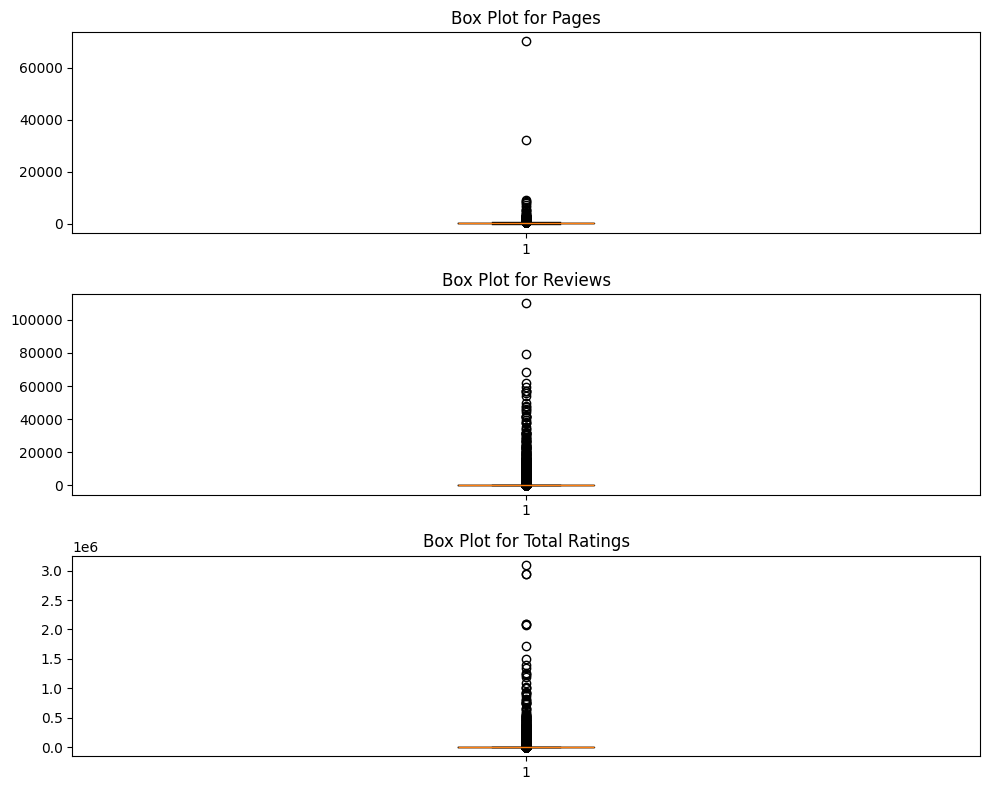

In [21]:
# Read data here
df = numerical_columns

# Create a new figure
plt.figure(figsize=(10, 8))

# Create a box plot for the 'pages' column
plt.subplot(3, 1, 1)
plt.boxplot(df['pages'], vert=True)
plt.title('Box Plot for Pages')

# Create a box plot for the 'reviews' column
plt.subplot(3, 1, 2)
plt.boxplot(df['reviews'], vert=True)
plt.title('Box Plot for Reviews')

# Create a box plot for the 'total_ratings' column
plt.subplot(3, 1, 3)
plt.boxplot(df['total_ratings'], vert=True)
plt.title('Box Plot for Total Ratings')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

The box plots for 'Pages', 'Reviews', and 'Total Ratings' indicate a significant number of outliers, especially for the 'Reviews' and 'Total Ratings' where the scale goes up to 100,000 and 1e6 (1,000,000) respectively. This can be identified by the points that are plotted as individual dots outside of the whiskers of the box plots.

Using the median to replace outliers is a common practice when we want to minimize the impact of extreme values on our data analysis. The median is robust to outliers because it is the middle value in a list of numbers and does not get affected by how large or small the outliers are. This makes it a good choice for maintaining the central tendency of our data without distorting it with extreme values.

By replacing outliers with the median, we're ensuring that the typical values in our dataset are represented more accurately, while also reducing potential skew caused by unusually high or low values. However, it's important to note that this approach does not preserve the distribution of our data. 

In this case the outliers don't seem to represent valid extreme variations in the data, so I might not be losing important variations by replacing them with the median.

Before proceeding with this method, I ensure that it aligns with the goals of my analysis and that I'm not discarding valuable information that outliers might represent, especially if they are a result of actual trends or behaviors in the underlying data.

In the case of "pages" the book with the most pages in the world has approximately 3,000 and here we see books of up to 70,000 pages which seems almost impossible.

In [22]:
# Define the columns where outliers will be replaced with the median
columns_to_replace = ['pages', 'reviews', 'total_ratings']

# Replace outliers with the median for each specified column
for column in columns_to_replace:
    median = books_df[column].median()
    q1 = books_df[column].quantile(0.25)
    q3 = books_df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    
    # Replace outliers with median
    books_df.loc[books_df[column] > upper_bound, column] = median
    books_df.loc[books_df[column] < lower_bound, column] = median

In [23]:
# With this done and updated
# Create again 2 separate DataFrames for numerical and categorical columns
numerical_columns = books_df.select_dtypes(include=['number'])
categorical_columns = books_df.select_dtypes(exclude=['number'])

In [24]:
# Check again Statistic description for the updated numericals
numerical_columns.describe().T

,count,mean,std,min,25%,50%,75%,max
pages,73719.0,258.888007,118.014126,1.0,186.0,261.00,329.00,596.0
rating,73719.0,3.899602,0.365694,0.0,3.7,3.92,4.13,5.0
reviews,73719.0,32.766098,42.063592,0.0,5.0,21.00,39.00,207.0
total_ratings,73719.0,349.242380,474.519952,0.0,54.0,212.00,382.00,2376.0


In the 'pages' column, we observe that there are books (or at least one book) with as few as one page, and the books with the fewest pages normally have around 50 pages. To handle this, I will impute the values for books with fewer than 50 pages with the median value.

In [25]:
# Count the number of books with less than 50 pages
books_less_than_50_pages = len(books_df[books_df['pages'] < 50])
print("Number of books with less than 50 pages:", books_less_than_50_pages)

# Calculate the percentage of books with less than 50 pages
percentage_less_than_50_pages = (books_less_than_50_pages / len(books_df)) * 100
print("Percentage of books with less than 50 pages:", percentage_less_than_50_pages, "%")

Number of books with less than 50 pages: 4323
Percentage of books with less than 50 pages: 5.864159850242136 %


Only 5% of the data.

In [26]:
# Calculate the median of the 'pages' column
median_pages = books_df['pages'].median()

# Replace values less than 50 with the median
books_df.loc[books_df['pages'] < 50, 'pages'] = median_pages

In [27]:
# Define again this variables just in case
numerical_columns = books_df.select_dtypes(include=['number'])
categorical_columns = books_df.select_dtypes(exclude=['number'])

In [28]:
# Check the changes
numerical_columns.describe().T

,count,mean,std,min,25%,50%,75%,max
pages,73719.0,272.271463,103.656554,50.0,204.0,261.00,329.00,596.0
rating,73719.0,3.899602,0.365694,0.0,3.7,3.92,4.13,5.0
reviews,73719.0,32.766098,42.063592,0.0,5.0,21.00,39.00,207.0
total_ratings,73719.0,349.242380,474.519952,0.0,54.0,212.00,382.00,2376.0


### Distribution of Numerical Features

I use histograms to visualize the distribution of 'pages', 'rating', and 'total_ratings'. This will help to understand the spread of the data and understand the central tendency.

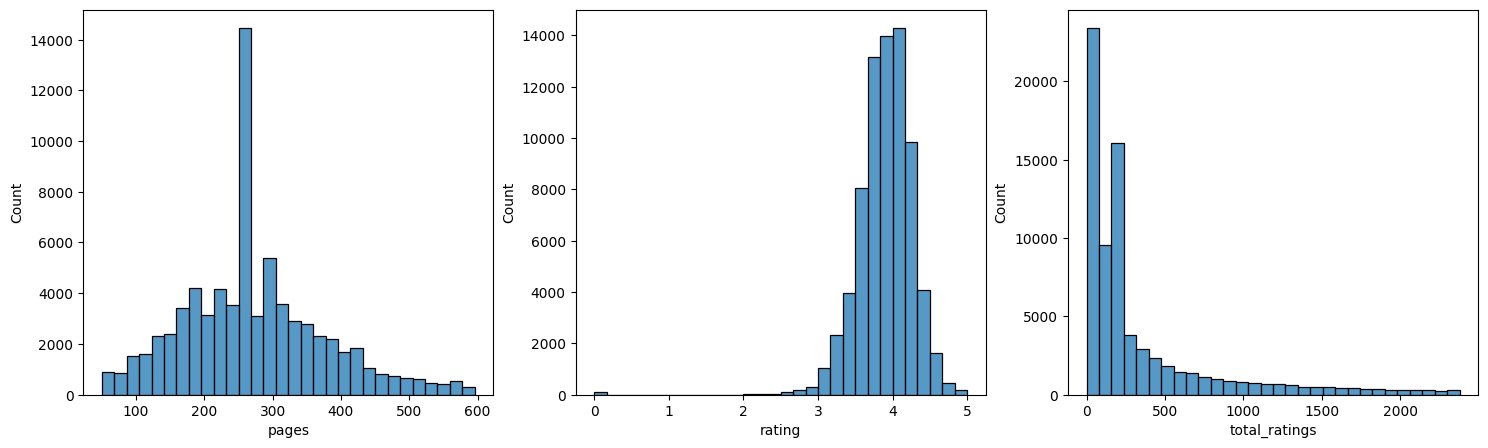

In [29]:
# Check the distribution of 'pages', 'rating', and 'total_ratings'
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(books_df['pages'], bins=30, ax=ax[0])
sns.histplot(books_df['rating'], bins=30, ax=ax[1])
sns.histplot(books_df['total_ratings'], bins=30, ax=ax[2])
plt.show()

- The histogram for **pages** shows a unimodal distribution with a peak at lower page counts, indicating that most books in the dataset have a relatively small number of pages. There are fewer books with a very high page count, as seen by the long tail of the distribution.

- The **rating** histogram is skewed towards higher ratings, with many books having ratings close to 5. This could suggest either a selection bias towards highly-rated books or that readers tend to give higher ratings.

- The **total_ratings** histogram also shows a skew, with most books having a smaller number of total ratings, which is typical for a large collection of books where only a few become extremely popular or widely rated.

### Count of Books by Genre

A bar chart showing the number of books in each genre can highlight the most common genres in the dataset.

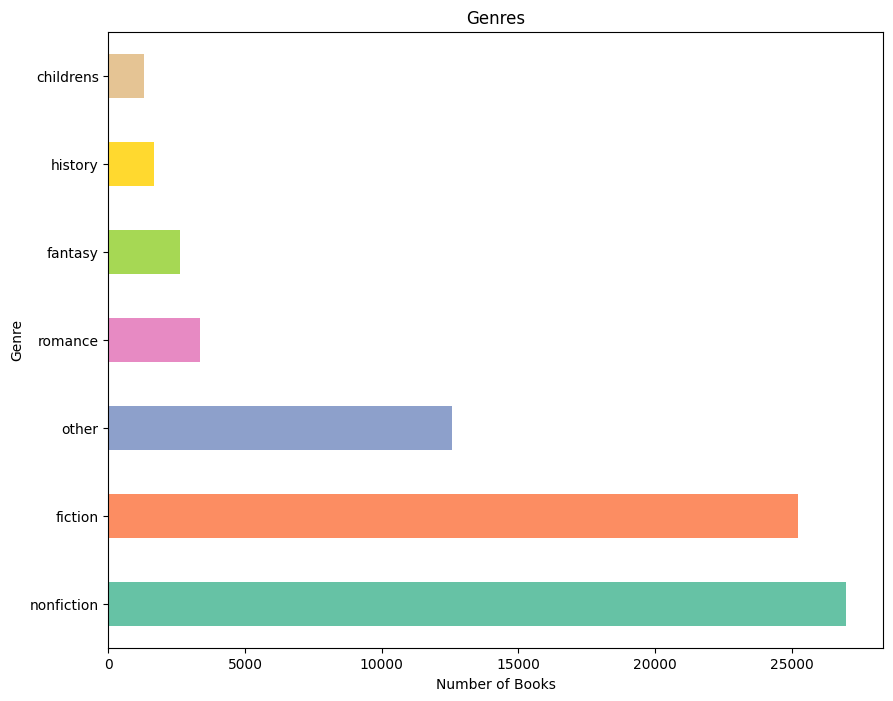

In [30]:
# Create a color palette for the genres
genre_colors = sns.color_palette("Set2", n_colors=len(books_df['genre'].unique()))

# Count of books by genre
plt.figure(figsize=(10, 8))
genre_counts = books_df['genre'].value_counts().head(20)
genre_counts.plot(kind='barh', color=genre_colors)
plt.title('Genres')
plt.xlabel('Number of Books')
plt.ylabel('Genre')
plt.show()

- The bar chart of genres indicates that **nonfiction and fiction are the most common genres** within the dataset. This suggests that the dataset has a broad representation of both factual and creative literature.

- The genres after nonfiction and fiction, including other, romance, fantasy, history, and childrens, have significantly fewer books. This could point to potential opportunities for targeting niche markets or underscore the need for a more balanced dataset if the goal is to provide recommendations across a wide variety of genres. (Due time constrictions I can't make this improvements now for this project).

### Correlation Heatmap

I want to see if there's a correlation between 'rating', 'total_ratings', and 'pages'. A heatmap can visually represent these relationships.

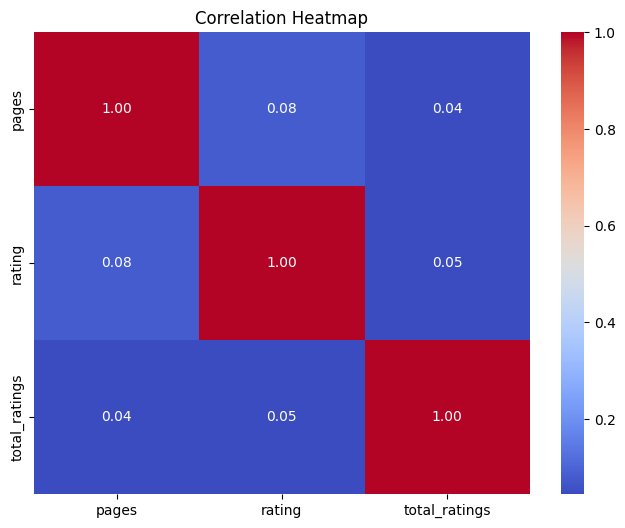

In [31]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(books_df[['pages', 'rating', 'total_ratings']].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

- The correlation heatmap provides an overview of the linear relationship between the numerical features. It seems that **there is no strong correlation between any of the pairs of features**.

- The lack of strong correlation means that these features provide unique information about the books, which is beneficial for a clustering model because it means that each feature could contribute to distinguishing between different clusters of books.

#### Overall Insights (summary):

- The dataset likely contains a wide range of books but is dominated by those with fewer pages and higher ratings.
- There is an opportunity to analyze why certain books have more ratings and if that correlates with higher sales or popularity.
- The dominance of nonfiction and fiction genres suggests these are popular or common categories for books; however, it would be valuable to investigate the distribution within the "other" category.
- When building a recommender system, the lack of strong correlation between features indicates that each feature could potentially add value in distinguishing user preferences. However, the high volume of books with fewer pages and higher ratings might skew recommendation results towards these books unless balanced by other factors such as personal user history or diversity algorithms.

These insights can help guide further analysis, such as looking into the specifics of the "other" genre, considering balancing factors for popular books in recommendations, or exploring the long tail of less common books for niche interests.

### Word Cloud for Descriptions

A word cloud for the 'description' column can show the most frequently occurring words, which might give insights into common themes or subjects.

In [32]:
books_df["description"].unique()

array(['Reveals that several hundred thousand Indians were affected by the Civil War and that twenty thousand Indians enlisted on both sides in an attempt to gain legitimacy, autonomy, or simply land.',
       'Fashion Sourcebook - 1920s is the first book in a brand-new series by Fiell Publishing that documents comprehensively the seasonal fashion styles of the 20th century, decade by decade. Sumptuously illustrated with over 600 original photographs, drawings and prints, this title is a must-have reference work for not only students of fashion, but for all fashionistas. Fashion Sourcebook - 1920s focuses on the Art Deco period with its beautiful beaded dresses, cloche hats and t-bar shoes as worn by the fashionable flappers and the "bright young things" of the time. An accompanying introduction outlines the major themes within fashion during this period and introduces its most famous designers and assesses their creative contributions. Text in English, French & German. Also Available:

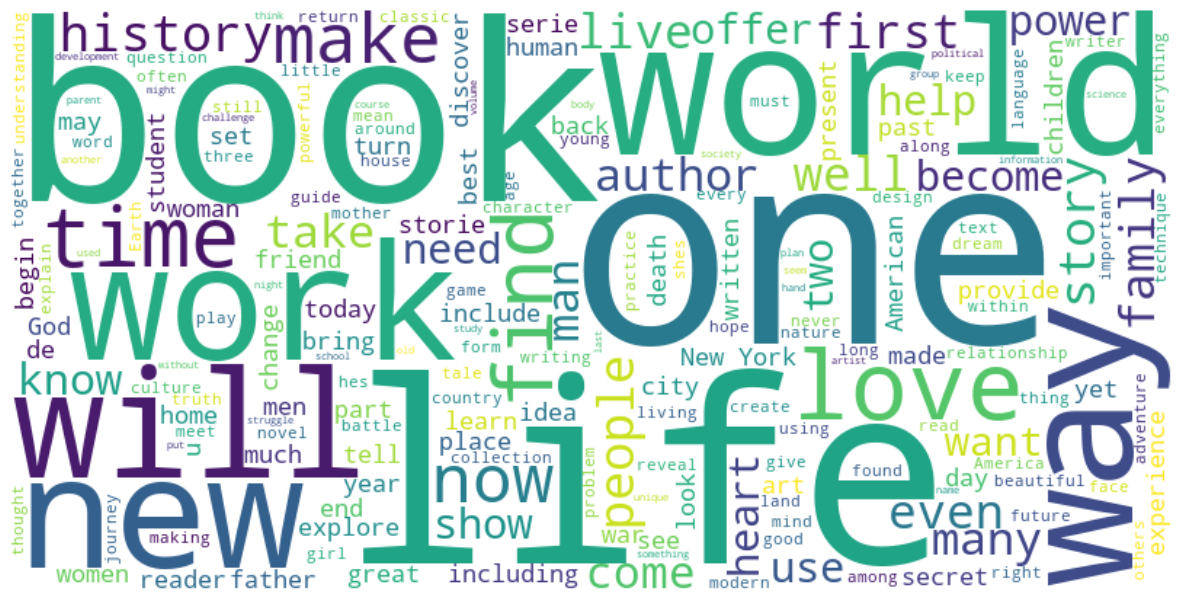

In [33]:
# Function to clean the description text
def clean_description(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove anything that is not a letter or space
    text = re.sub(r'[^A-Za-z ]+', '', text)
    # Remove single standalone letters
    text = re.sub(r'\s[b-zB-Z]\s', ' ', text)
    # Remove extra spaces
    text = ' '.join(text.split())
    return text

# Apply the function to clean the descriptions
books_df['cleaned_description'] = books_df['description'].astype(str).apply(clean_description)

# Create a text string for the Word Cloud
description_text = ' '.join(books_df['cleaned_description'].dropna())

# Generate and display the Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(description_text)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


This word cloud is a visual representation of the frequency of words appearing in the book descriptions within the dataset. In a word cloud, the size of each word is proportional to its frequency: the larger the word, the more often it appears in the descriptions.

From this word cloud, we can draw several insights:

1. **Common Themes**: Words like "world," "story," "life," "people," and "new" are very prominent, indicating these are common elements in book descriptions. This suggests that themes of life experiences, storytelling, and new beginnings or worlds are frequently mentioned, perhaps to capture potential readers' interest.

2. **Emotional and Inspirational Language**: Words like "heart," "dream," "love," and "help" point to emotional and inspirational content, which could be indicative of the types of narratives or themes that are popular or engaging for readers.

3. **Descriptive and Engaging Language**: The presence of words like "adventure," "history," "secret," "power," and "culture" shows that descriptions often include words that set an exciting tone or imply depth and intrigue, possibly to entice readers with the promise of an engaging read.

4. **Action and Outcome**: Words such as "make," "take," "find," and "come" suggest a focus on action and outcomes in the narratives, which might be key elements that the descriptions are highlighting to potential readers.

5. **Relationships and Characters**: The words "man," "women," "people," and "reader" indicate that relationships and characters play significant roles in these books. It also reflects an attempt to connect with the reader by addressing them directly or discussing relatable characters.

The word cloud can guide publishers and authors in understanding what types of content are prevalent or popular and can inform marketing strategies by highlighting what draws readers' attention in book descriptions. For a recommendation system, understanding these common words and themes could help in tagging books or matching users' interests with book content.

### Replace "description" with the cleaned description column

In [34]:
books_df.head()

,author,description,image_url,url,pages,rating,reviews,title,total_ratings,genre,cleaned_description
0,Laurence M. Hauptman,Reveals that several hundred thousand Indians ...,https://i.gr-assets.com/images/S/compressed.ph...,https://goodreads.com/book/show/1001053.Betwee...,261,3.52,5,Between Two Fires: American Indians in the Civ...,33,nonfiction,Reveals that several hundred thousand Indians ...
1,"Charlotte Fiell,Emmanuelle Dirix",Fashion Sourcebook - 1920s is the first book i...,https://i.gr-assets.com/images/S/compressed.ph...,https://goodreads.com/book/show/10010552-fashi...,576,4.51,6,Fashion Sourcebook 1920s,41,nonfiction,Fashion Sourcebook is the first book in a bran...
2,Andy Anderson,The seminal history and analysis of the Hungar...,https://i.gr-assets.com/images/S/compressed.ph...,https://goodreads.com/book/show/1001077.Hungar...,124,4.15,2,Hungary 56,26,history,The seminal history and analysis of the Hungar...
3,Carlotta R. Anderson,"""All-American Anarchist"" chronicles the life a...",https://i.gr-assets.com/images/S/compressed.ph...,https://goodreads.com/book/show/1001079.All_Am...,324,3.83,1,All-American Anarchist: Joseph A. Labadie and ...,6,history,AllAmerican Anarchist chronicles the life and ...
4,Jeffrey Pfeffer,Why is common sense so uncommon when it comes ...,https://i.gr-assets.com/images/S/compressed.ph...,https://goodreads.com/book/show/1001090.The_Hu...,368,3.73,7,The Human Equation: Building Profits by Puttin...,119,nonfiction,Why is common sense so uncommon when it comes ...


In [35]:
# Drop the original column
books_df.drop(columns=['description'], inplace=True)

In [36]:
# Replace and rename
books_df.rename(columns={'cleaned_description': 'description'}, inplace=True)

In [37]:
# Check
books_df.columns

Index(['author', 'image_url', 'url', 'pages', 'rating', 'reviews', 'title',
       'total_ratings', 'genre', 'description'],
      dtype='object')

In [38]:
# Check null values
books_df.isnull().sum()

author           0
image_url        0
url              0
pages            0
rating           0
reviews          0
title            0
total_ratings    0
genre            0
description      0
dtype: int64

## Saving

In [39]:
# Save the DataFrame to a CSV file
books_df.to_csv('books_df_eda.csv', index=False)

## Additional EDA

### Genre and Total Ratings

In [40]:
# Pivot table for the sum of total_ratings for each genre
pivot_total_ratings = pd.pivot_table(books_df, values='total_ratings', index='genre', aggfunc=np.sum)

In [41]:
pivot_total_ratings

,total_ratings
genre,
childrens,154163
fantasy,1118882
fiction,13888941
history,53747
nonfiction,8709366
other,968296
romance,852404


/var/folders/09/qkspll5d37l0g2941hv9rvs80000gn/T/ipykernel_22332/873071068.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pivot_total_ratings.index, y=pivot_total_ratings['total_ratings'], palette='Set3')


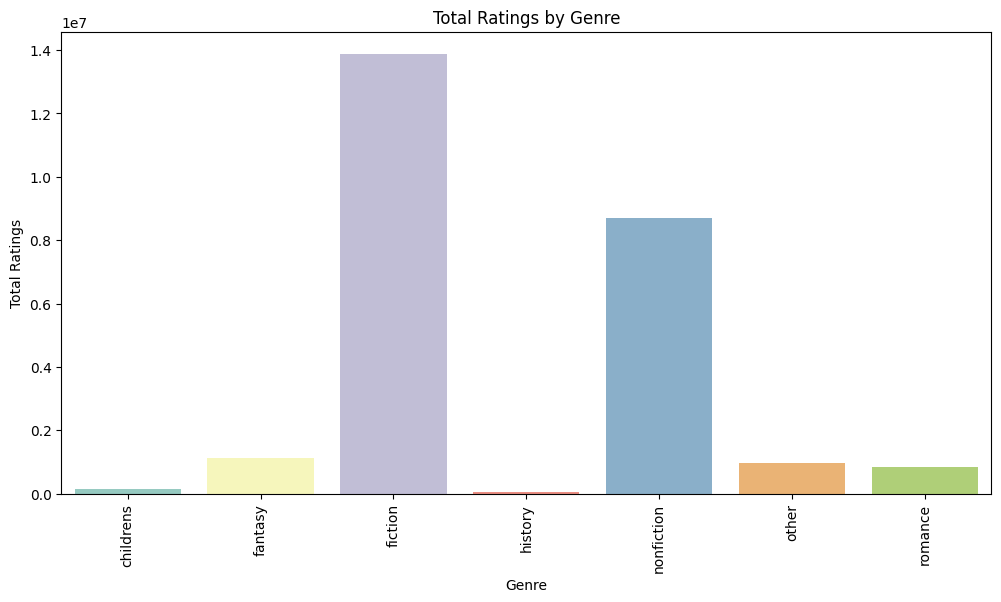

In [42]:
# Create a bar plot with different colors for each genre
plt.figure(figsize=(12, 6))
sns.barplot(x=pivot_total_ratings.index, y=pivot_total_ratings['total_ratings'], palette='Set3')
plt.title('Total Ratings by Genre')
plt.xlabel('Genre')
plt.ylabel('Total Ratings')
plt.xticks(rotation=90)
plt.show()

**Total Ratings by Genre:** The bar graph displays the cumulative total ratings of books across different genres. 

Fiction leads with the highest number of ratings, suggesting its popularity among readers, followed by nonfiction and romance. This could indicate a strong reader engagement in these genres. The relatively lower ratings for genres like children's, fantasy, history, and others may reflect a smaller number of works or a niche audience.

### Genre and Average Rating

In [43]:
# Pivot table for the average rating for each genre
pivot_average_rating = pd.pivot_table(books_df, values='rating', index='genre', aggfunc=lambda x: round(np.mean(x), 1))

In [44]:
pivot_average_rating

,rating
genre,
childrens,3.8
fantasy,3.9
fiction,3.9
history,3.9
nonfiction,4.0
other,3.9
romance,3.8


/var/folders/09/qkspll5d37l0g2941hv9rvs80000gn/T/ipykernel_22332/379653060.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pivot_average_rating.index, y=pivot_average_rating['rating'], palette='Set3')


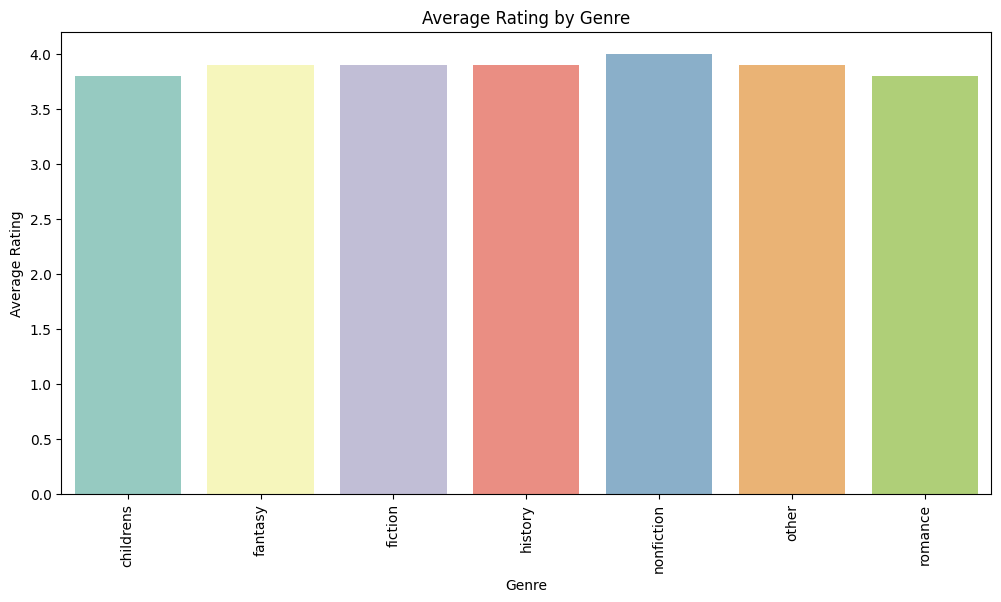

In [45]:
# Create a bar plot with different colors for each genre
plt.figure(figsize=(12, 6))
sns.barplot(x=pivot_average_rating.index, y=pivot_average_rating['rating'], palette='Set3')
plt.title('Average Rating by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=90)
plt.show()

**Average Rating by Genre:** This bar graph shows the average ratings across genres. 

It appears that all the genres have similar average ratings, hovering around the 3.5 to 4.0 mark, indicating generally favorable reception across genres. The close range of average ratings suggests that, irrespective of genre, the quality of books is consistently recognized by readers.

### Most popular authors of the DataFrame

Based on total ratings

To determine the most popular authors in the books_df, I use the total_ratings column. The total_ratings column represents the total number of ratings each book has received, which can be used to assess the popularity of the book and, consequently, its author. I aggregate the total ratings for books by each author to find out which authors have the highest total ratings and are, therefore, the most popular in terms of reader engagement.

In [46]:
# Group the books by author and sum their total ratings
author_ratings = books_df.groupby('author')['total_ratings'].sum().reset_index()

# Sort the authors by total ratings in descending order to find the most popular ones
most_popular_authors = author_ratings.sort_values(by='total_ratings', ascending=False)

# Display the top 10 most popular authors 
top_n = 10
print(f"Top {top_n} Most Popular Authors:")
most_popular_authors.head(top_n)

Top 10 Most Popular Authors:


,author,total_ratings
30661,Louis L'Amour,56849
31076,Lynn Hagen,51593
31140,Lynne Graham,48714
36283,Naoki Urasawa,35246
4205,Barbara Michaels,35143
18289,Harry Turtledove,32086
40188,Radclyffe,31006
2796,Ann Rinaldi,27679
40033,R.L. Stine,24801
1785,Amber Kell,24690


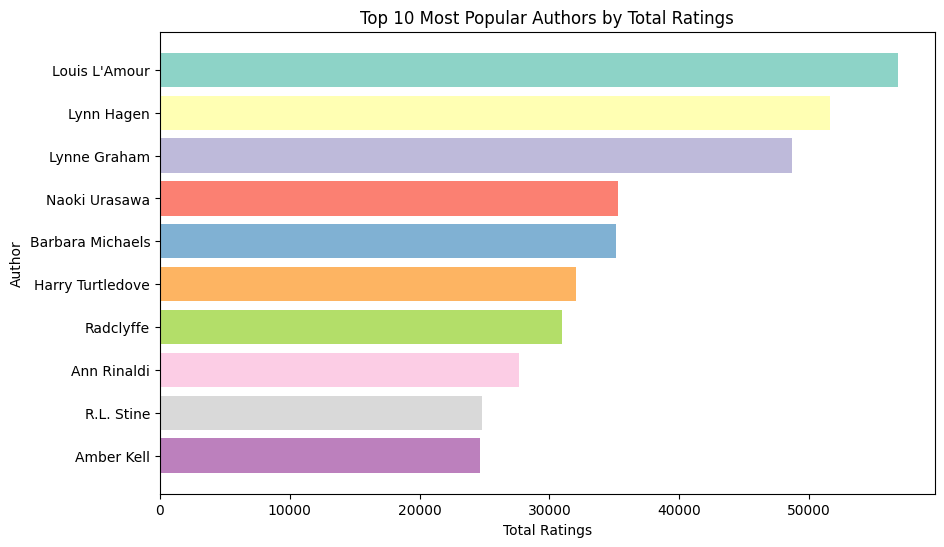

In [47]:
top_authors = most_popular_authors.head(top_n)

# Create a color palette for the bars
colors = sns.color_palette('Set3', n_colors=top_n)

# Create a horizontal bar plot with different colors for each bar
plt.figure(figsize=(10, 6))
plt.barh(top_authors['author'], top_authors['total_ratings'], color=colors)
plt.xlabel('Total Ratings')
plt.ylabel('Author')
plt.title(f'Top {top_n} Most Popular Authors by Total Ratings')
plt.gca().invert_yaxis()  # Invert the y-axis to display the highest ratings at the top
plt.show()

**Top 10 Most Popular Authors by Total Ratings:** This horizontal bar graph ranks authors by the total ratings received for their books. 

The graph suggests that certain authors have a significant impact on readers, given their high rating counts. This could be used to identify authors who have a strong following or whose works resonate well with the reading community.

### Popular authors and genre

In [48]:
# Merge the top_authors DataFrame with the original books_df to get genres associated with each author
top_authors_with_genres = pd.merge(top_authors, books_df[['author', 'genre']], on='author', how='left')

# Group by author and aggregate the associated unique genres as a list
author_genre_groups = top_authors_with_genres.groupby('author')['genre'].agg(lambda x: list(set(x))).reset_index()

# Display the top authors along with their associated unique genres as a list
author_genre_groups

,author,genre
0,Amber Kell,"[fiction, fantasy, romance]"
1,Ann Rinaldi,[fiction]
2,Barbara Michaels,[fiction]
3,Harry Turtledove,"[fantasy, fiction]"
4,Louis L'Amour,[fiction]
5,Lynn Hagen,"[fantasy, romance]"
6,Lynne Graham,"[fiction, romance]"
7,Naoki Urasawa,[fiction]
8,R.L. Stine,[fiction]
9,Radclyffe,"[fiction, romance]"


The table lists authors alongside the genres associated with their most rated books. This provides insights into the diversity of genres popular authors write in, with some spanning across romance, fiction, and fantasy. It reflects the authors' versatility and the breadth of appeal their works have across different reader interests.

These kind of insights can inform publishers and writers about prevailing reader preferences, guide marketing strategies, and potentially influence the direction of new writing projects to align with popular genres or to fill gaps in less represented ones.